In [1]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

In [2]:
def get_grid_points(sam_input_size, points_per_side):
    """
    Generate a grid of query points for SAM.

    Args:
        sam_input_size (int): Input size for SAM.
        points_per_side (int): Number of points per side.

    Returns:
        torch.Tensor: Grid points coordinates.
    """
    x, y = torch.meshgrid(
        torch.linspace(0, sam_input_size-1, points_per_side),
        torch.linspace(0, sam_input_size-1, points_per_side),
        indexing='ij'
    )
    query_points = torch.stack((y.reshape(-1), x.reshape(-1)), dim=-1)
    query_points += 0.5
    return query_points

Loaded and resized image to (1024, 1024)
Generated 1024 points
Shape: torch.Size([1024, 2])


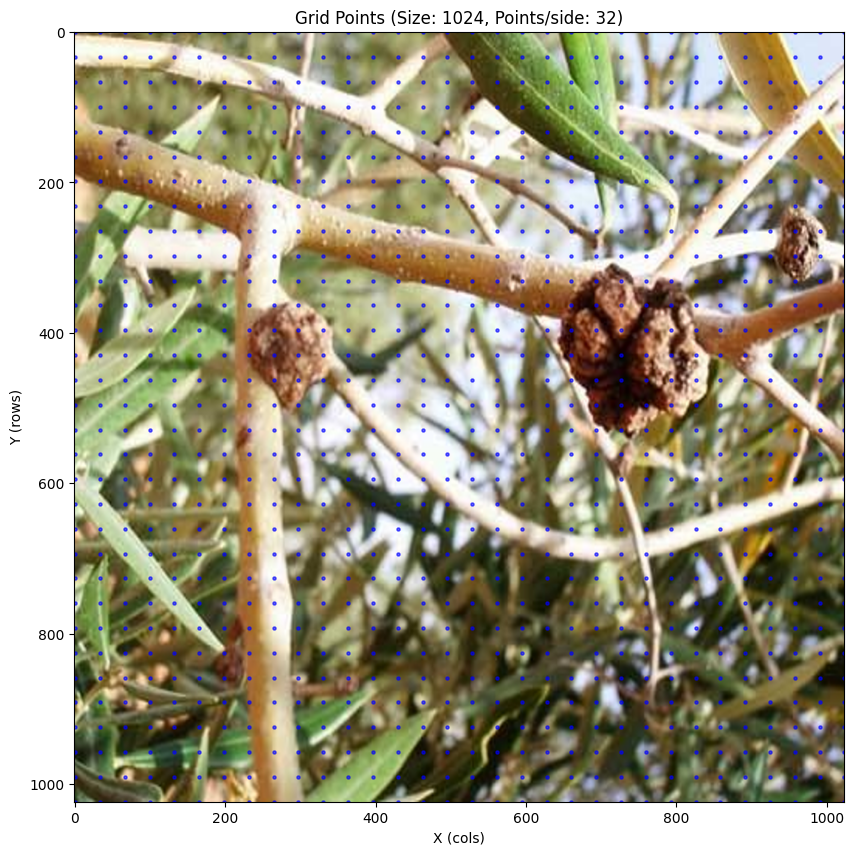

In [3]:
sam_input_size = 1024
points_per_side = 32

# Load image
image_path = '../data/olive_diseases/train2017/000000000001.jpg'
if not os.path.exists(image_path):
    print(f"Warning: Image not found at {image_path}")
else:
    image = Image.open(image_path)
    image = image.resize((sam_input_size, sam_input_size))
    print(f"Loaded and resized image to {image.size}")

points = get_grid_points(sam_input_size, points_per_side)

print(f"Generated {len(points)} points")
print(f"Shape: {points.shape}")

plt.figure(figsize=(10, 10))
if os.path.exists(image_path):
    plt.imshow(image)
plt.scatter(points[:, 0], points[:, 1], s=5, c='blue', alpha=0.6)
# plt.xlim(0, sam_input_size)
# plt.ylim(sam_input_size, 0) # Invert Y for image coordinate system
plt.title(f"Grid Points (Size: {sam_input_size}, Points/side: {points_per_side})")
plt.xlabel("X (cols)")
plt.ylabel("Y (rows)")
plt.grid(False) # Turn off grid lines as they might be confusing on top of image
# plt.axis('off')

plt.show()

Hydra initialized with /Users/mac/Developer/VScode/no-time-to-train/sam2_configs
Loading SAM2 from /Users/mac/Developer/VScode/no-time-to-train/checkpoints/sam2_hiera_large.pt...
Device: cpu
Predicting masks for all 1024 points...
Processed batch 1/4
Processed batch 2/4
Processed batch 3/4
Processed batch 4/4
Generated 1024 masks.


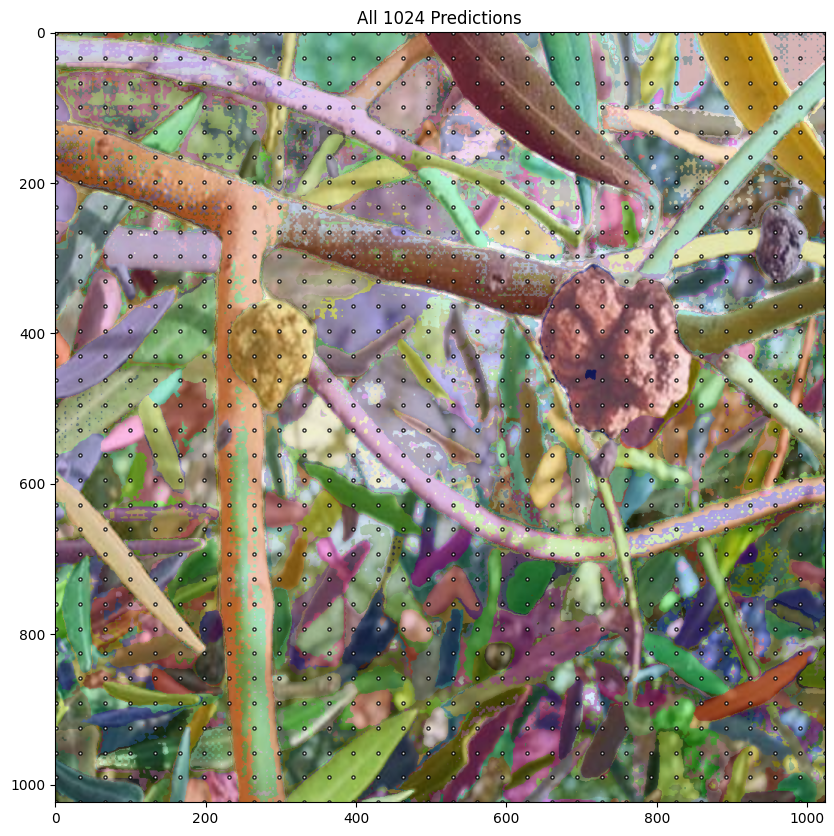

In [4]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import hydra
from hydra.core.global_hydra import GlobalHydra

# Add project root to path if not already there
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Helper functions for visualization
def show_anns(anns, ax):
    if len(anns) == 0:
        return
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# Paths
checkpoint_path = os.path.join(project_root, "checkpoints/sam2_hiera_large.pt")
config_dir = os.path.join(project_root, "sam2_configs")
config_name = "sam2_hiera_l.yaml"

# Initialize Hydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

try:
    hydra.initialize_config_dir(config_dir=config_dir, version_base='1.2')
    print(f"Hydra initialized with {config_dir}")
except Exception as e:
    print(f"Hydra initialization warning: {e}")

# Build SAM2 Model
print(f"Loading SAM2 from {checkpoint_path}...")
# Force CPU to avoid MPS 'upsample_bicubic2d' NotImplementedError on some versions
device = "cpu"
print(f"Device: {device}")

if not os.path.exists(checkpoint_path):
    print(f"Error: Checkpoint not found at {checkpoint_path}")
else:
    sam2_model = build_sam2(config_file=config_name, ckpt_path=checkpoint_path, device=device)
    predictor = SAM2ImagePredictor(sam2_model)

    # Set image for prediction
    predictor.set_image(np.array(image))

    # --- Run on ALL points in batches ---
    print(f"Predicting masks for all {len(points)} points...")
    points_np = points.numpy()

    batch_size = 256

    all_masks = []
    all_scores = []

    with torch.no_grad():
        for i in range(0, len(points_np), batch_size):
            batch_points = points_np[i:i+batch_size]
            batch_points = batch_points[:, None, :]
            batch_labels = np.ones((len(batch_points), 1), dtype=np.int32)

            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                point_coords=batch_points,
                point_labels=batch_labels,
                box=None,
                mask_logits=None,
                normalize_coords=True,
            )

            masks, scores, logits = predictor._predict(
                unnorm_coords,
                labels,
                unnorm_box,
                mask_input,
                multimask_output=False,
            )

            masks = masks.squeeze(1).cpu().numpy() > 0
            scores = scores.squeeze(1).cpu().numpy()

            all_masks.append(masks)
            all_scores.append(scores)

            print(f"Processed batch {i // batch_size + 1}/{(len(points_np) + batch_size - 1) // batch_size}")

    all_masks = np.concatenate(all_masks, axis=0)
    all_scores = np.concatenate(all_scores, axis=0)
    print(f"Generated {len(all_masks)} masks.")

    # Visualize all predictions
    anns = []
    for i in range(len(all_masks)):
        m = all_masks[i]
        anns.append({
            'segmentation': m,
            'area': np.sum(m),
            'score': float(all_scores[i]),
        })

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_anns(anns, plt.gca())
    plt.scatter(points_np[:, 0], points_np[:, 1], s=5, c='white', alpha=0.8, edgecolors='black')
    plt.title(f"All {len(all_masks)} Predictions")
    plt.show()